<a href="https://colab.research.google.com/github/StitchMl/Intrusion-Detection/blob/main/Traccia_T7b_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to the Project

The main objective of this project is to develop a machine learning system capable of analysing network traffic and classifying flows as 'normal' or associated with a specific type of attack, using the `KDDTrainClean.csv` dataset.

#Data Setup

##1. Loading the dataset

In this section, we load the dataset and analyse its structure to understand its main characteristics.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import gdown

###**Loading the dataset**

In [2]:
file_id = "1-h3FXJTy57RQzO3uNSWhNA5wN8k_HTwB"
file_url = f"https://drive.google.com/uc?id={file_id}"
output_path = "KDDTrainClean.csv"

try:
    # Scarica il file
    gdown.download(file_url, output_path, quiet=False)

    # Carica il dataset
    dataset = pd.read_csv(output_path)
    print("Dataset successfully loaded!")
except Exception as e:
    print(f"Error: {e}")


Downloading...
From: https://drive.google.com/uc?id=1-h3FXJTy57RQzO3uNSWhNA5wN8k_HTwB
To: /content/KDDTrainClean.csv
100%|██████████| 17.2M/17.2M [00:00<00:00, 52.8MB/s]


Dataset successfully loaded!


###**Initial exploration**

We will check:

In [3]:
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


The structure of the dataset (number of rows and columns).

In [4]:
print("Size of dataset (rows, columns):", dataset.shape)

Size of dataset (rows, columns): (125973, 42)


The data types in each column.

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

The presence of any null values.

In [6]:
null_counts = dataset.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.any() else "There are no null values in the dataset.")

There are no null values in the dataset.


###**Analysis of class distribution**

The label column represents the label associated with each network flow (e.g. 'normal' or a specific type of attack). We will calculate the class distribution and display the results with a bar graph.

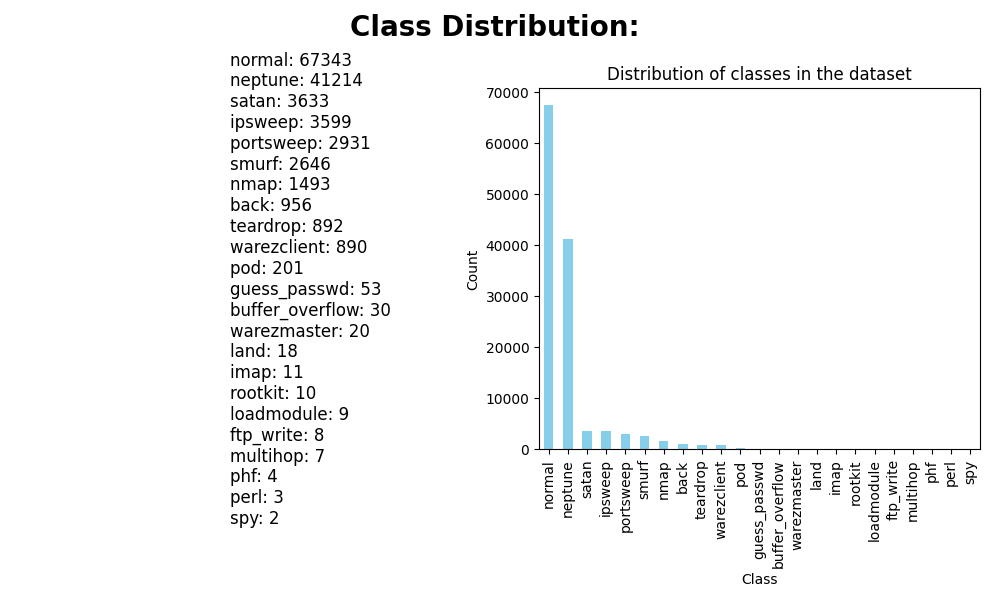

In [7]:
class_distribution = dataset['label'].value_counts()

# Visualisation of class distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Class Distribution:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = "\n\n"+"\n".join([f"{key}: {value}" for key, value in class_distribution.items()])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="left", va="center")
class_distribution.plot(kind='bar', color='skyblue')
ax[1].set_title("Distribution of classes in the dataset")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()  # Improve layout
plt.show()

The analysis of the `label` column shows that some classes (e.g. `spy`) are **represented by an extremely small number of examples** (only 2) and that many other classes have fewer than 50 examples, indicating a significant scarcity of data for these categories. This imbalance in the distribution of classes could lead to the least represented classes being neglected in favour of the most common ones.

*Classes with few examples may not be correctly learnt by the model*, resulting in poor performance (low precision and recall) on these categories, while the overall accuracy may appear high, but this metric would not reflect the true ability of the model to correctly classify smaller classes.

In this case, it may be possible to compensate for the imbalance by **using approaches such as class weighting** (e.g. `class_weight` in Scikit-learn or Keras) **or the use of metrics such as F1-score, precision and recall per class** that provide a more accurate view of the model's performance on the lesser represented classes.




##2. Cleaning and preprocessing

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

###**Management of null values**

After an initial analysis of the dataset, it was verified that no null values were present. Therefore, there is no need to apply data imputation or removal techniques.

###**Normalisation of numerical features**

All numerical features in the dataset are normalised using the Standard Scaler, so that they have a mean of zero and a unit standard deviation.

In [9]:
# Identifying numeric columns
numeric_columns = dataset.select_dtypes(include=np.number).columns
numeric_columns = list(numeric_columns)  # Convert to list

# Number of columns per row
num_cols_per_row = 3
col_width = 25  # Fixed width for each column

# Format output on multiple columns with fixed spacing
print("Number columns identified:")
for i in range(0, len(numeric_columns), num_cols_per_row):
    row = [name.ljust(col_width) for name in numeric_columns[i:i+num_cols_per_row]]
    print("- " + "\t- ".join(row))

Number columns identified:
- duration                 	- src_bytes                	- dst_bytes                
- land                     	- wrong_fragment           	- urgent                   
- hot                      	- num_failed_logins        	- logged_in                
- num_compromised          	- root_shell               	- su_attempted             
- num_root                 	- num_file_creations       	- num_shells               
- num_access_files         	- num_outbound_cmds        	- is_host_login            
- is_guest_login           	- count                    	- srv_count                
- serror_rate              	- srv_serror_rate          	- rerror_rate              
- srv_rerror_rate          	- same_srv_rate            	- diff_srv_rate            
- srv_diff_host_rate       	- dst_host_count           	- dst_host_srv_count       
- dst_host_same_srv_rate   	- dst_host_diff_srv_rate   	- dst_host_same_src_port_rate
- dst_host_srv_diff_host_rate	- dst_host_serror

In [10]:
# Applying the scaler standard
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])

###**Label Encoding**

The label column is converted into numerical values using the Label Encoding algorithm.

In [11]:
# Codifica delle etichette
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])

print("The labels were converted into numerical values.")
print("Mapping the original classes:\n")

# Numero di colonne per riga
num_cols_per_row = 3
col_width = 30  # Larghezza fissa per ogni colonna

# Creazione della lista dei mapping con indice + nome della classe
mapping = [f"{index}: {class_label}" for index, class_label in enumerate(label_encoder.classes_)]

# Calcolo del numero massimo di righe
max_rows = (len(mapping) + num_cols_per_row - 1) // num_cols_per_row

# Stampa formattata su tre colonne rispettando l'ordine
for row in range(max_rows):
    row_entries = []
    for col in range(num_cols_per_row):
        index = row + col * max_rows  # Calcola l'indice effettivo per ogni colonna
        if index < len(mapping):
            row_entries.append(mapping[index].ljust(col_width))  # Allinea a sinistra
        else:
            row_entries.append("".ljust(col_width))  # Spazio vuoto se non ci sono più elementi
    print(" ".join(row_entries))

The labels were converted into numerical values.
Mapping the original classes:

0: back                        8: multihop                    16: rootkit                   
1: buffer_overflow             9: neptune                     17: satan                     
2: ftp_write                   10: nmap                       18: smurf                     
3: guess_passwd                11: normal                     19: spy                       
4: imap                        12: perl                       20: teardrop                  
5: ipsweep                     13: phf                        21: warezclient               
6: land                        14: pod                        22: warezmaster               
7: loadmodule                  15: portsweep                                                


Do the same for non-numerical features (`protocol_type`, `service`, `flag`)

In [12]:
protocol_encoder = LabelEncoder()
dataset['protocol_type'] = protocol_encoder.fit_transform(dataset['protocol_type'])
print("The features were converted into numerical values.")
print("Mapping the original classes of protocol_type:")
for index, class_label in enumerate(protocol_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The features were converted into numerical values.
Mapping the original classes of protocol_type:
  0:	icmp
  1:	tcp
  2:	udp


In [13]:
service_encoder = LabelEncoder()
dataset['service'] = service_encoder.fit_transform(dataset['service'])
print("The features were converted into numerical values.")
print("Mapping the original classes of service:\n")

# Numero di colonne per riga
num_cols_per_row = 4
col_width = 30  # Larghezza fissa per ogni colonna

# Creazione della lista dei mapping con indice + nome della classe
mapping = [f"{index}: {class_label}" for index, class_label in enumerate(service_encoder.classes_)]

# Calcolo del numero massimo di righe
max_rows = (len(mapping) + num_cols_per_row - 1) // num_cols_per_row

# Stampa formattata su tre colonne rispettando l'ordine
for row in range(max_rows):
    row_entries = []
    for col in range(num_cols_per_row):
        index = row + col * max_rows  # Calcola l'indice effettivo per ogni colonna
        if index < len(mapping):
            row_entries.append(mapping[index].ljust(col_width))  # Allinea a sinistra
        else:
            row_entries.append("".ljust(col_width))  # Spazio vuoto se non ci sono più elementi
    print(" ".join(row_entries))

The features were converted into numerical values.
Mapping the original classes of service:

0: IRC                         18: finger                     36: name                       54: smtp                      
1: X11                         19: ftp                        37: netbios_dgm                55: sql_net                   
2: Z39_50                      20: ftp_data                   38: netbios_ns                 56: ssh                       
3: aol                         21: gopher                     39: netbios_ssn                57: sunrpc                    
4: auth                        22: harvest                    40: netstat                    58: supdup                    
5: bgp                         23: hostnames                  41: nnsp                       59: systat                    
6: courier                     24: http                       42: nntp                       60: telnet                    
7: csnet_ns                    25: http

In [14]:
flag_encoder = LabelEncoder()
dataset['flag'] = flag_encoder.fit_transform(dataset['flag'])
print("The features were converted into numerical values.")
print("Mapping the original classes of flag:")
for index, class_label in enumerate(flag_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The features were converted into numerical values.
Mapping the original classes of flag:
  0:	OTH
  1:	REJ
  2:	RSTO
  3:	RSTOS0
  4:	RSTR
  5:	S0
  6:	S1
  7:	S2
  8:	S3
  9:	SF
  10:	SH


After these steps, the data set is ready for model training. The changes made ensure that the data are in a consistent and optimal format for analysis.

##3. Exploratory analysis

In this section, we focus on two main aspects:
* Correlation between numerical characteristics
* Distribution of classes.

In [15]:
import seaborn as sns

###**Correlation Analysis**

The correlation matrix is calculated, representing the degree of linear relationship between each pair of numerical characteristics.

In [16]:
correlation_matrix = dataset.corr()

Visualise the matrix with a heatmap using the `seaborn` library. Darker cells indicate a strong, positive or negative correlation.

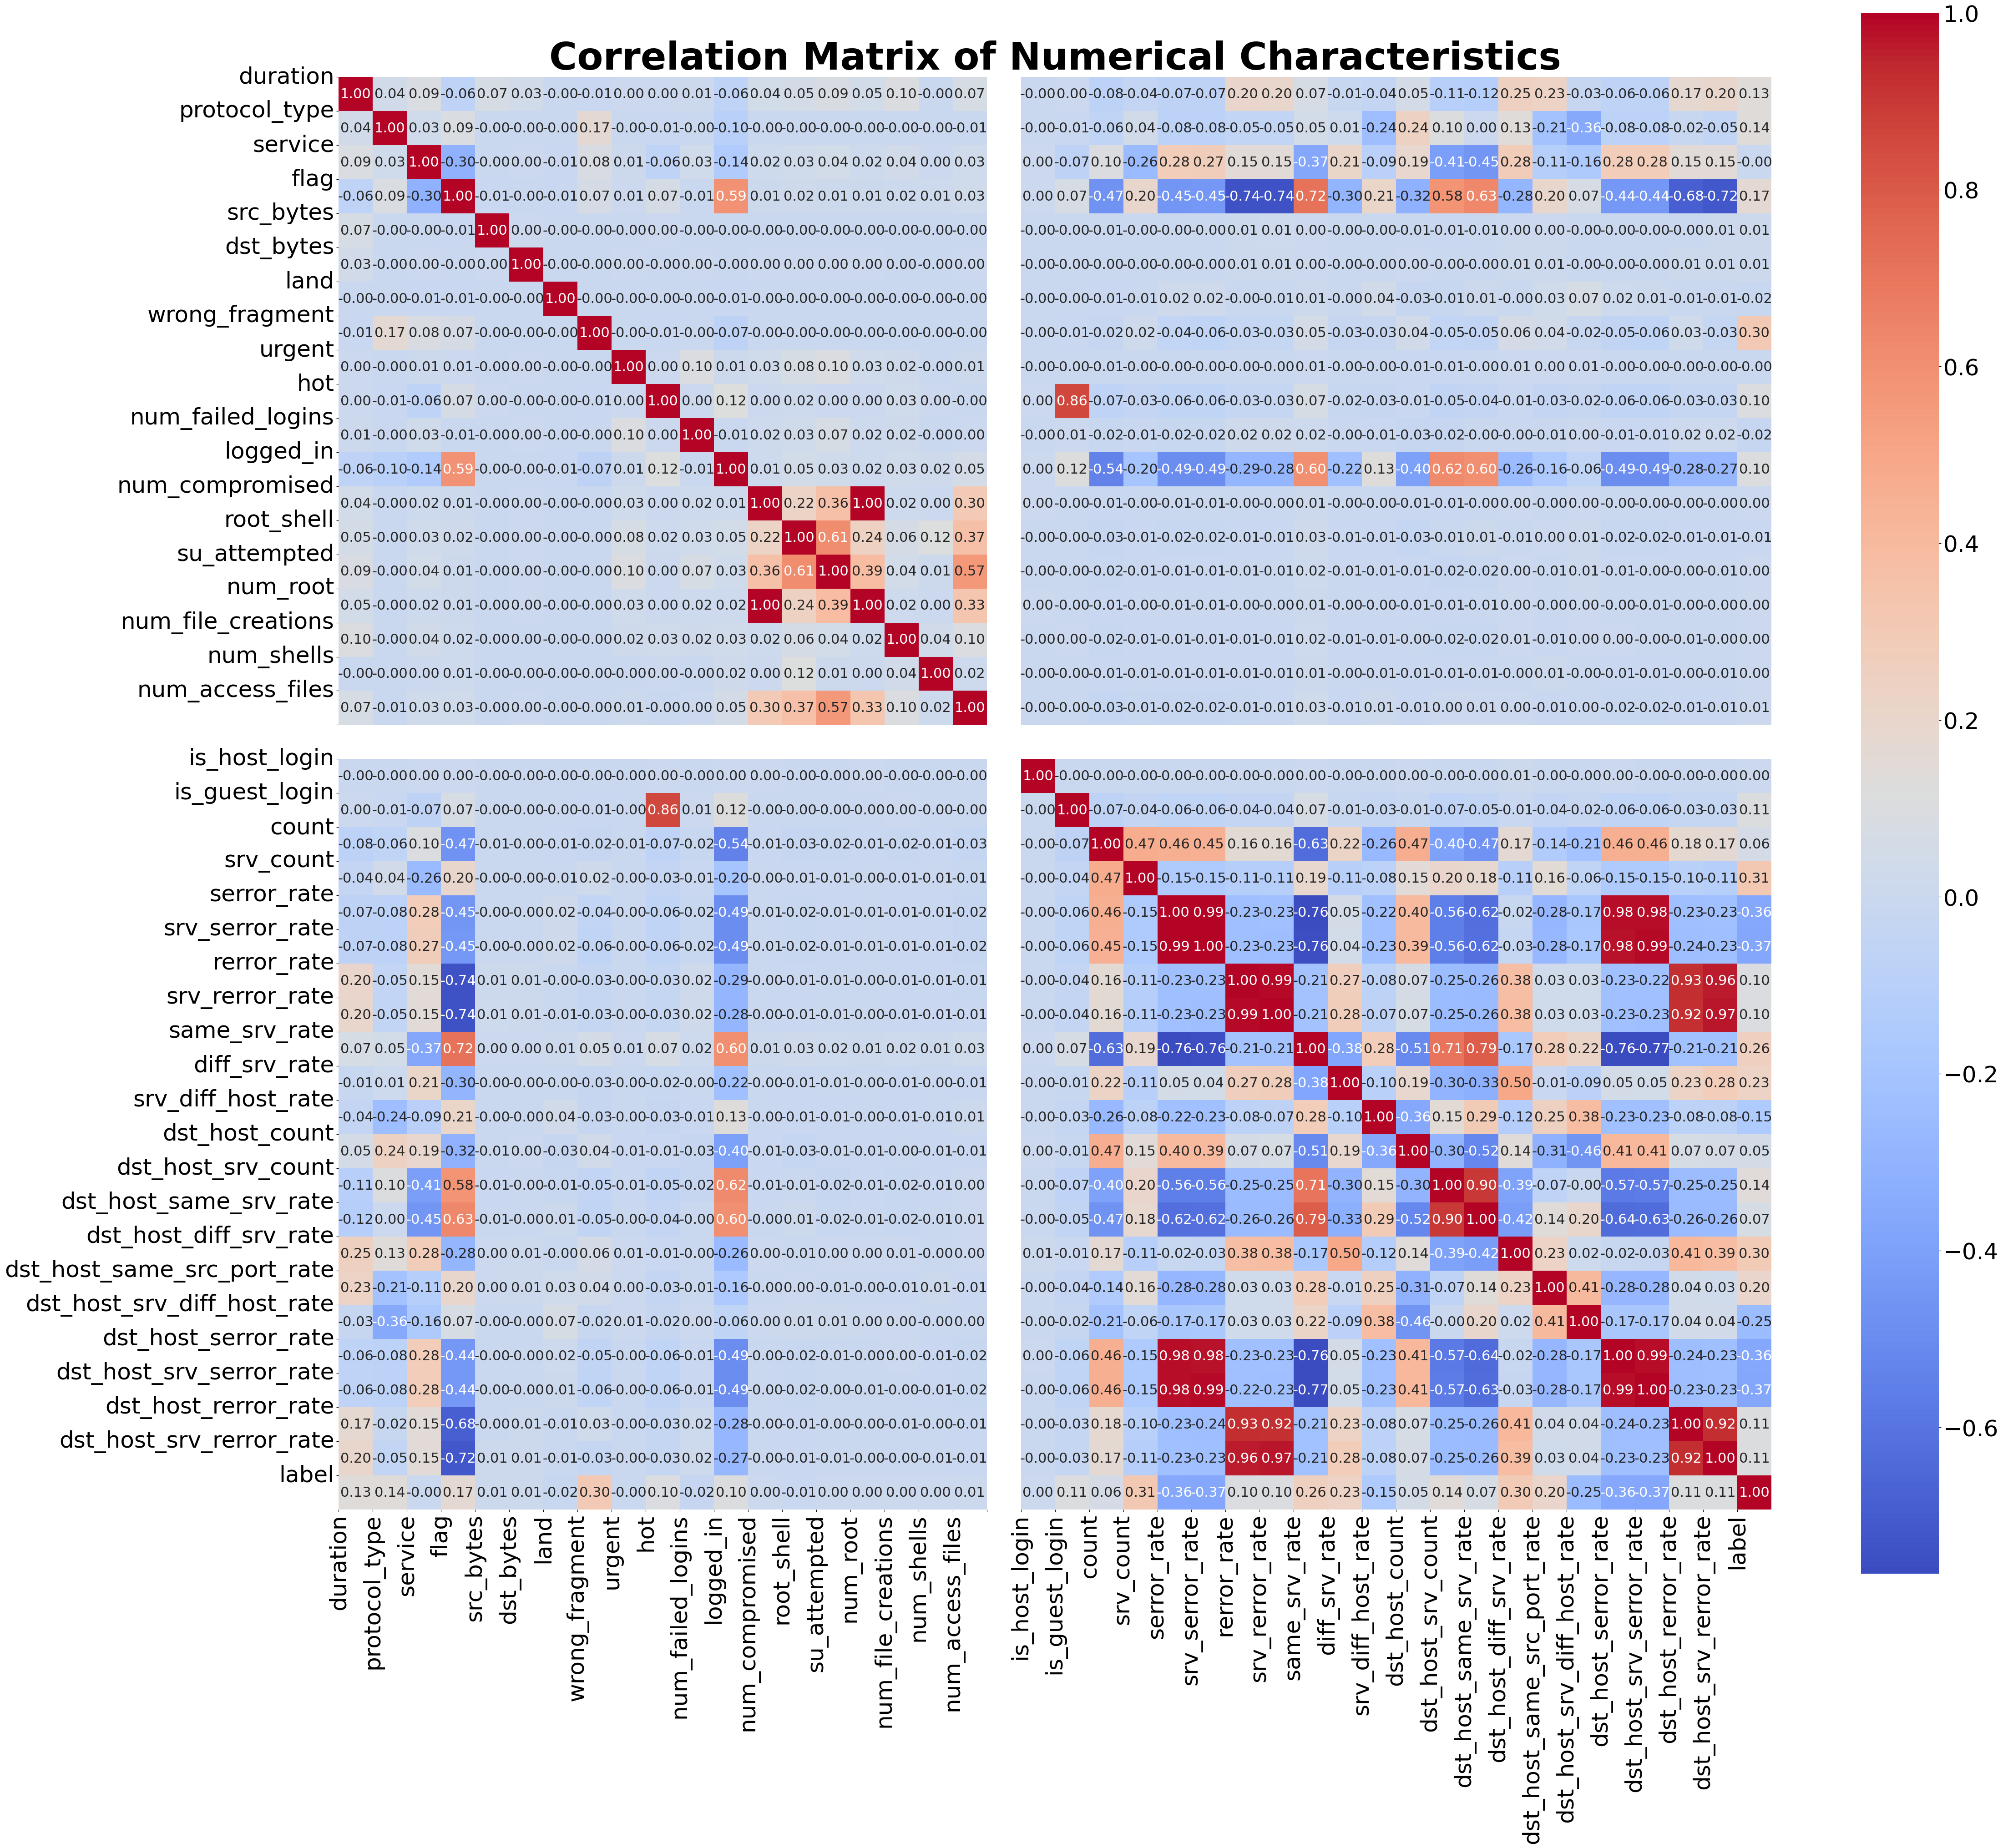

In [17]:
# Calculates the dynamic dimensions of the figure based on the number of variables
num_variables = correlation_matrix.shape[0]
cell_size = 1  # Basic size of each cell in inches
fig_width = cell_size * num_variables + 5  # Dynamic width
fig_height = cell_size * num_variables + 5  # Dynamic height

# Create heatmap with proportionate size
plt.figure(figsize=(fig_width, fig_height))
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,  # Show values in cells
    cmap="coolwarm",  # Colormap
    fmt=".2f",  # Format of values
    cbar=True,  # Colour bar
    square=True,  # Create square cells for a uniform layout
    annot_kws={"size": 22},  # Increases the font of values in cells
    cbar_kws={"shrink": 0.8, "aspect": 20,}  # Reduces the size of the colour bar
)

# Customise colourbar font
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=36)  # Font of colourbar values

# Remove only the label 'num_outbound_cmds' from the axes
labels = correlation_matrix.columns.tolist()  # Get all labels
filtered_labels = [label if label != "num_outbound_cmds" else "" for label in labels]  # Replace with empty string

# Set up customised labels
plt.xticks(ticks=range(len(filtered_labels)), labels=filtered_labels, rotation=90, fontsize=36)
plt.yticks(ticks=range(len(filtered_labels)), labels=filtered_labels, rotation=0, fontsize=36)

plt.title("Correlation Matrix of Numerical Characteristics", fontsize=60, fontweight="bold")
plt.tight_layout()
plt.show()

We identify feature pairs with absolute correlation above a predefined threshold. These highly correlated features can be considered redundant and potentially removed to improve the efficiency and performance of the model.

In [18]:
threshold = 0.8  # Threshold for high correlations
high_corr_pairs = correlation_matrix[
    (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)]
print("Highly correlated pairs of characteristics (threshold > 0.8):")
processed_columns = set()  # Set to keep track of already processed columns
columns_to_remove = set()  # Set to store columns to be removed
for col in high_corr_pairs.columns:
    if col not in processed_columns:
        # Find all related features for this column
        correlated_features = high_corr_pairs.index[high_corr_pairs[col].notna()].tolist()
        # Filter already processed features
        correlated_features = [feature for feature in correlated_features
                               if feature not in processed_columns]
        if correlated_features:
            print(f" - {col}: {correlated_features}")
            # Add related columns to the removal list (except the main column)
            columns_to_remove.update(correlated_features)
        # Add the column and its correlates to the set of processed columns
        processed_columns.update(correlated_features + [col])

Highly correlated pairs of characteristics (threshold > 0.8):
 - hot: ['is_guest_login']
 - num_compromised: ['num_root']
 - serror_rate: ['srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
 - rerror_rate: ['srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
 - dst_host_srv_count: ['dst_host_same_srv_rate']


Highly correlated columns are removed to improve the performance and efficiency of the model.

In [19]:
print("Removing highly correlated columns:")
columns_to_remove = list(columns_to_remove)
print(columns_to_remove)

dataset = dataset.drop(columns=columns_to_remove, axis=1)
print("\nSize of dataset (rows, columns):", dataset.shape)

Removing highly correlated columns:
['srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'num_root', 'dst_host_rerror_rate', 'srv_serror_rate', 'is_guest_login', 'dst_host_srv_rerror_rate']

Size of dataset (rows, columns): (125973, 33)


###Distribution of classes

We analyse and visualise the distribution of the classes in the dataset in order to understand any imbalances in the labels and decide whether to implement further transformations of the dataset and/or the choice of suitable evaluation metrics.

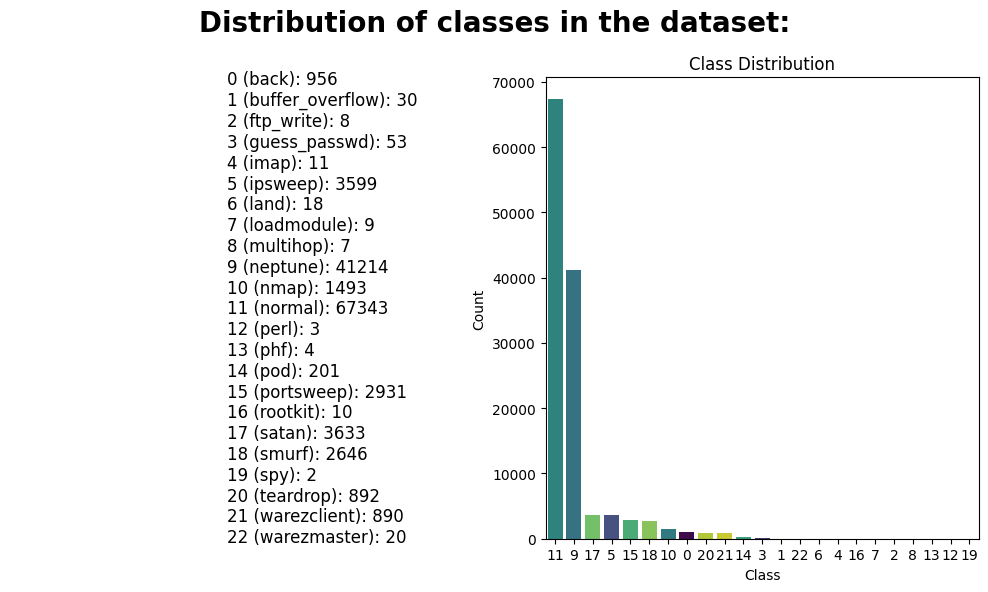

In [20]:
class_distribution = dataset['label'].value_counts()
class_distribution = class_distribution.sort_values(ascending=False)

# Distribution bar graph
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Distribution of classes in the dataset:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = ""+"\n".join([f"{index} ({class_label}): {class_distribution[index]}" for index, class_label in enumerate(label_encoder.classes_)])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="left", va="center")
sns.barplot(x=class_distribution.index, y=class_distribution.values,
            palette="viridis", order=class_distribution.index,  # Specific order for the graph
            hue=class_distribution.index, legend=False)
ax[1].set_title("Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

Given the large overestimation of values for the class `Neptune` and the class `Normal`, it was considered to reduce the number of parameters by removing duplicate or too similar values of these two classes.

In [21]:
# Identifica le due classi più popolate
class_counts = dataset['label'].value_counts()
top_classes = class_counts.index[:2]  # Seleziona le due classi più numerose

In [22]:
# Rimuovi solo i duplicati per le due classi più numerose
def remove_duplicates(group):
    return group.drop_duplicates()

dataset = dataset.groupby('label')[dataset.columns.tolist()].apply(
    lambda group: remove_duplicates(group) if group.name in top_classes else group,
    include_groups=False
)

# Output della nuova distribuzione delle classi
class_distribution_limited = dataset['label'].value_counts()

print("Size of dataset (rows, columns):", dataset.shape)
print("Class distribution after removing duplicates in the two most populated classes:")
for index, class_label in enumerate(label_encoder.classes_):
    if index in class_distribution_limited:
        print(f"{index} ({class_label}): {class_distribution_limited[index]}")

Size of dataset (rows, columns): (125766, 33)
Class distribution after removing duplicates in the two most populated classes:
0 (back): 956
1 (buffer_overflow): 30
2 (ftp_write): 8
3 (guess_passwd): 53
4 (imap): 11
5 (ipsweep): 3599
6 (land): 18
7 (loadmodule): 9
8 (multihop): 7
9 (neptune): 41214
10 (nmap): 1493
11 (normal): 67136
12 (perl): 3
13 (phf): 4
14 (pod): 201
15 (portsweep): 2931
16 (rootkit): 10
17 (satan): 3633
18 (smurf): 2646
19 (spy): 2
20 (teardrop): 892
21 (warezclient): 890
22 (warezmaster): 20


After reducing the maximum number of elements for classes, we display the new distribution of labels in the dataset.

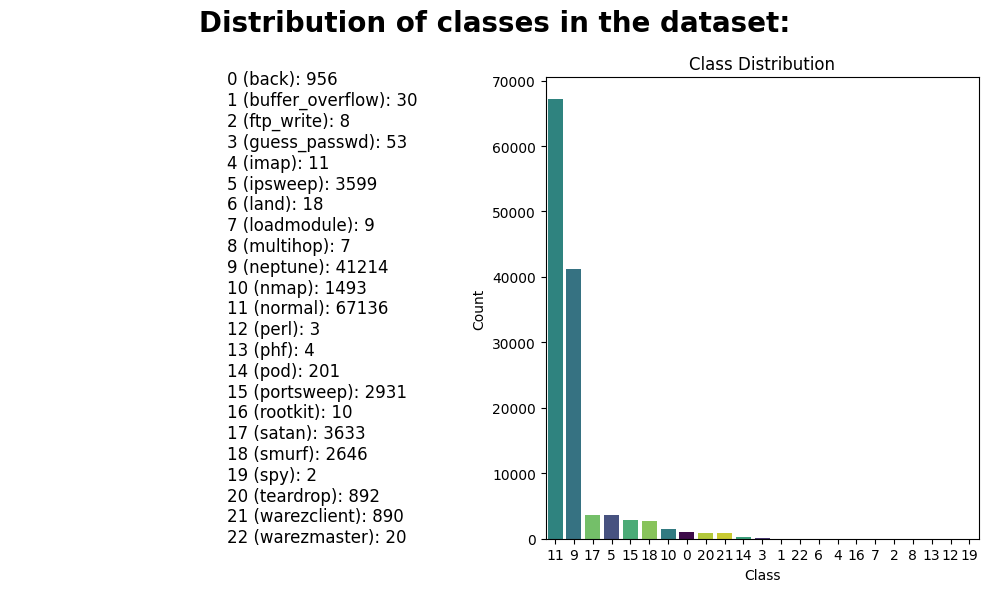

In [23]:
class_distribution = dataset['label'].value_counts()
class_distribution = class_distribution.sort_values(ascending=False)

# Distribution bar graph
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Distribution of classes in the dataset:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = ""+"\n".join([f"{index} ({class_label}): {class_distribution[index]}" for index, class_label in enumerate(label_encoder.classes_)])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="left", va="center")
sns.barplot(x=class_distribution.index, y=class_distribution.values,
            palette="viridis", order=class_distribution.index,  # Specific order for the graph
            hue=class_distribution.index, legend=False)
ax[1].set_title("Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

Since the cut of the dataset is not significant, we assign weights to the error of guessing the class, so that guessing classes with more elements (e.g. `Neptune` and `Normal`) is less important than guessing classes with fewer examples. This approach can help reduce the bias towards the more populous classes, ensuring that the model does not overly favour the more numerous classes at the expense of the less represented ones.

In [30]:
# Calcolare il numero di esempi per ogni classe
class_counts = dataset['label'].value_counts()

# Calcolare i pesi in modo inversamente proporzionale alla frequenza
max_class_count = class_counts.max()
weights = class_counts.apply(lambda x: max_class_count / x)

# Organizzare l'output su tre colonne
print("Class weights (more populated classes have lower weights):")

# Creare una lista di tuples (class_name, weight)
class_weights = [(label_encoder.classes_[class_index], weight) for class_index, weight in weights.items()]

# Numero di colonne
num_columns = 3

# Calcolare la larghezza massima per la formattazione
col_width = max(len(f"- {class_name}: {weight:.2f}  ") for class_name, weight in class_weights)

# Stampare in tre colonne ordinate
for i in range(0, len(class_weights), num_columns):
    row = class_weights[i:i + num_columns]
    row_output = "".join([f"- {class_name}: {weight:.2f}".ljust(col_width) for class_name, weight in row])
    print(row_output)

Class weights (more populated classes have lower weights):
- normal: 1.00              - neptune: 1.63             - satan: 18.48              
- ipsweep: 18.65            - portsweep: 22.91          - smurf: 25.37              
- nmap: 44.97               - back: 70.23               - teardrop: 75.26           
- warezclient: 75.43        - pod: 334.01               - guess_passwd: 1266.72     
- buffer_overflow: 2237.87  - warezmaster: 3356.80      - land: 3729.78             
- imap: 6103.27             - rootkit: 6713.60          - loadmodule: 7459.56       
- ftp_write: 8392.00        - multihop: 9590.86         - phf: 16784.00             
- perl: 22378.67            - spy: 33568.00             


##4. Division of the dataset

To train and evaluate machine learning models, the dataset is divided into three separate sets: Training, Validation and Testing.

In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

###**Separation of features and labels**

The columns of the dataset are divided into:
* Feature (`X`): These represent the features used as input for the model.
* Labels (`y`): They correspond to the label column, which indicates whether a flow is normal or associated with a type of attack.

In [32]:
X = dataset.drop(columns=['label'])  # Exclude the 'label' column for features
y = dataset['label']  # Labels

###**Class Balancing**

If the training set presents a significant imbalance between classes, the `SMOTE` (Synthetic Minority Oversampling Technique) is used. This technique generates synthetic samples for the least represented classes, improving the predictive capabilities of the model.

In [34]:
balance_with_smote = False  # Change to True if you wish to apply SMOTE
if balance_with_smote:
    print("Application of SMOTE for class balancing in the Training set...")

    # Calculate class distribution
    class_counts = y.value_counts()

    # Defining the sampling strategy
    sampling_strategy = {
        label: max(20, count)  # If the number of examples is less than 20, we increase to 20
        for label, count in class_counts.items() if count < 20
    }

    # Apply SMOTE only to classes with fewer than 10 examples
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=min(5, y.value_counts().min() - 1))
    X_balanced, y_balanced = smote.fit_resample(X, y)

    print("Successfully balanced training set!")
    print("Class distribution after SMOTE:")
    for index, class_label in enumerate(label_encoder.classes_):
        if index in y_balanced.value_counts().index:  # Check if the index is present
            print(f"{index} ({class_label}): {y_balanced.value_counts()[index]}")
        else:
            print(f"{index} ({class_label}): 0")  # Print 0 if not present
else:
    X_balanced, y_balanced = X, y
    print("The choice was made not to use SMOTE...")
    print("Class distribution without SMOTE:")
    for index, class_label in enumerate(label_encoder.classes_):
        if index in y_balanced.value_counts().index:  # Check if the index is present
            print(f"{index} ({class_label}): {y_balanced.value_counts()[index]}")
        else:
            print(f"{index} ({class_label}): 0")  # Print 0 if not present

The choice was made not to use SMOTE...
Class distribution without SMOTE:
0 (back): 956
1 (buffer_overflow): 30
2 (ftp_write): 8
3 (guess_passwd): 53
4 (imap): 11
5 (ipsweep): 3599
6 (land): 18
7 (loadmodule): 9
8 (multihop): 7
9 (neptune): 41214
10 (nmap): 1493
11 (normal): 67136
12 (perl): 3
13 (phf): 4
14 (pod): 201
15 (portsweep): 2931
16 (rootkit): 10
17 (satan): 3633
18 (smurf): 2646
19 (spy): 2
20 (teardrop): 892
21 (warezclient): 890
22 (warezmaster): 20


It was decided to not create synthetic samples

###**Suddivisione dei dati**

The dataset is divided into three sets with the following proportions:
* **Training set** (70%): to train the model.
* **Validation set** (15%): to optimise parameters and evaluate performance during training.
* **Test set** (15%): to evaluate the final performance of the model.

Stratification (`stratify`) ensures that the distribution of classes is uniform between the different sets.

In [35]:
# Initial division into Training+Validation and Test set (85%-15%)
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced)

# Breakdown of Training+Validation into Training (70%) and Validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

print(f"Set sizes:")
print(f"Training set (rows, columns): {X_train.shape}\nValidation set (rows, columns): {X_val.shape}\nTest set (rows, columns): {X_test.shape}")

Set sizes:
Training set (rows, columns): (88032, 32)
Validation set (rows, columns): (18869, 32)
Test set (rows, columns): (18865, 32)


In [36]:
# Stampa la distribuzione delle classi nel training set su tre colonne
print("Class distribution in sets:")
print("Training set:")

# Creare una lista di tuples (class_name, count)
class_counts_train = [(label_encoder.classes_[class_index], y_train.value_counts()[class_index])
                      for class_index in range(len(label_encoder.classes_))]

# Numero di colonne
num_columns = 3

# Calcolare la larghezza massima per la formattazione
col_width = max(len(f"{class_name}: {count}") for class_name, count in class_counts_train)

# Stampare in tre colonne ordinate
for i in range(0, len(class_counts_train), num_columns):
    row = class_counts_train[i:i + num_columns]
    row_output = "     ".join([f"{class_name}: {count}".ljust(col_width) for class_name, count in row])
    print(row_output)

Class distribution in sets:
Training set:
back: 670               buffer_overflow: 21     ftp_write: 6       
guess_passwd: 37        imap: 7                 ipsweep: 2519      
land: 12                loadmodule: 7           multihop: 5        
neptune: 28849          nmap: 1045              normal: 46993      
perl: 2                 phf: 2                  pod: 141           
portsweep: 2051         rootkit: 7              satan: 2543        
smurf: 1852             spy: 2                  teardrop: 624      
warezclient: 623        warezmaster: 14    


In [37]:
print("Validation set:")
# Creiamo una lista di tuples (index, class_label, count)
class_counts = [(index, class_label, y_val.value_counts().get(index, 0)) for index, class_label in enumerate(label_encoder.classes_)]

# Numero di colonne
num_columns = 3

# Calcolare la larghezza massima per la formattazione
col_width = max(len(f"{index} ({class_label}): {count}") for index, class_label, count in class_counts)

# Stampare in tre colonne ordinate
for i in range(0, len(class_counts), num_columns):
    row = class_counts[i:i + num_columns]
    row_output = "     ".join([f"{index} ({class_label}): {count}".ljust(col_width) for index, class_label, count in row])
    print(row_output)

Validation set:
0 (back): 143              1 (buffer_overflow): 4     2 (ftp_write): 1      
3 (guess_passwd): 8        4 (imap): 2                5 (ipsweep): 540      
6 (land): 3                7 (loadmodule): 1          8 (multihop): 1       
9 (neptune): 6183          10 (nmap): 224             11 (normal): 10073    
12 (perl): 1               13 (phf): 1                14 (pod): 30          
15 (portsweep): 440        16 (rootkit): 2            17 (satan): 545       
18 (smurf): 397            19 (spy): 0                20 (teardrop): 134    
21 (warezclient): 133      22 (warezmaster): 3   


In [38]:
# Stampa la distribuzione delle classi nel test set su 3 colonne
print("Test set:")
class_counts_test = y_test.value_counts()

# Crea una lista di tuples (index, class_label, count)
class_info = [(index, label_encoder.classes_[index], class_counts_test.get(index, 0)) for index in range(len(label_encoder.classes_))]

# Numero di colonne
num_columns = 3

# Calcolare la larghezza massima per la formattazione
col_width = max(len(f"{index} ({class_label}): {count}") for index, class_label, count in class_info)

# Stampare in tre colonne ordinate
for i in range(0, len(class_info), num_columns):
    row = class_info[i:i + num_columns]
    row_output = "     ".join([f"{index} ({class_label}): {count}".ljust(col_width) for index, class_label, count in row])
    print(row_output)

Test set:
0 (back): 143              1 (buffer_overflow): 5     2 (ftp_write): 1      
3 (guess_passwd): 8        4 (imap): 2                5 (ipsweep): 540      
6 (land): 3                7 (loadmodule): 1          8 (multihop): 1       
9 (neptune): 6182          10 (nmap): 224             11 (normal): 10070    
12 (perl): 0               13 (phf): 1                14 (pod): 30          
15 (portsweep): 440        16 (rootkit): 1            17 (satan): 545       
18 (smurf): 397            19 (spy): 0                20 (teardrop): 134    
21 (warezclient): 134      22 (warezmaster): 3   


#Model development and selection

##1. Selection of algorithms

We are going to train and evaluate two machine learning models for multiclass classification of the dataset. The performance of a traditional model and a neural network will be compared.

In [58]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score

###**Random Forest**

This model is known for its ability to handle noisy data and identify the most important features.

In [56]:
print("Random Forest model training...")
rand = np.random.randint(0, 101)
# Convert the weights Series to a dictionary
weights_dict = weights.to_dict()
rf_model = RandomForestClassifier(random_state=rand, class_weight=weights_dict)
rf_history = rf_model.fit(X_train, y_train)

Random Forest model training...


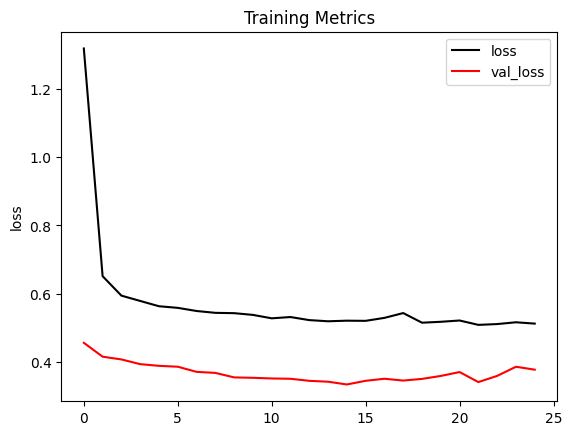

In [65]:
def plot_rf_training(rf_model) -> None:
    """ Plot loss and val_loss """
    history_df = pd.DataFrame(history.history)

    plt.figure('loss')
    plt.plot(history_df['loss'], label='loss', c='black')
    plt.plot(history_df['val_loss'], label='val_loss', c='red')
    plt.title('Training Metrics')
    plt.ylabel('loss')
    plt.xticks(rotation=0)
    plt.legend()
    plt.show()

plot_rf_training(rf_history)

In [66]:
# Predictions on Validation Set
rf_predictions = rf_model.predict(X_val)

####**Evaluation**

Performance is measured using a classification report (Precision, Recall, F1-score for each class) and the overall accuracy on the validation set.

In [67]:
print("Evaluation of the Random Forest model:")

# Generates the classification report as a dictionary
report_dict = classification_report(y_val, rf_predictions, zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, rf_predictions):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, rf_predictions, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, rf_predictions, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, rf_predictions, average='weighted'):.2f}")

Evaluation of the Random Forest model:
                    precision    recall  f1-score   support
0 (back)                  1.0       1.0       1.0     143.0
1 (buffer_overflow)       1.0       0.5  0.666667       4.0
2 (ftp_write)             1.0       1.0       1.0       1.0
3 (guess_passwd)          1.0     0.875  0.933333       8.0
4 (imap)                  1.0       0.5  0.666667       2.0
5 (ipsweep)          0.994465  0.998148  0.996303     540.0
6 (land)                 0.75       1.0  0.857143       3.0
7 (loadmodule)            0.5       1.0  0.666667       1.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.999838  0.999838  0.999838    6183.0
10 (nmap)            0.995495  0.986607  0.991031     224.0
11 (normal)          0.997424  0.999504  0.998463   10073.0
12 (perl)                 1.0       1.0       1.0       1.0
13 (phf)                  1.0       1.0       1.0       1.0
14 (pod)                  1.0       1.0       1.0      30.0
1

###**Rete Neurale Multilayer Perceptron (MLP)**

A fully connected neural network designed to capture complex patterns in data.

In [46]:
print("Preparation of data for the MLP model...")
# Conversion of labels into categorical format for the neural network
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
input_dim = X_train.shape[1]  # Number of input features
num_classes = y_train_cat.shape[1]  # Number of classes

Preparation of data for the MLP model...


An input layer with **128 neurons** and `ReLU` activation.
A `Dropout` layer to prevent overfitting.
A second hidden layer with **64 neurons** and `ReLU` activation.
An output layer with `Softmax` activation for multiclass classification.

In [52]:
print("Creation of the MLP model...")

def create_model(
        k: int, # number of classes
        input_s: tuple,
        dropout_rate: float = 0,  # rate for dropout layers
    ) -> Sequential:
    """ Create Sequential model for multiclass classifier """
    model = Sequential([Input(shape=input_s)])
    model.add(Dense(16, activation='relu'))
    if dropout_rate != 0:
            model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    if dropout_rate != 0:
            model.add(Dropout(0.5))
    model.add(Dense(k, activation='softmax'))
    return model

input_shape = (X_train.shape[1],)
mlp_model = create_model(num_classes, input_shape, 1)

Creation of the MLP model...


In [53]:
def compile(model: Sequential) -> None:
    """ Compile model """
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizers.Adam(learning_rate=0.001),
        metrics = ['f1_score']
    )

compile(mlp_model)

####**Training**

Use `categorical_crossentropy` loss function. Trained for **20 epochs** with a **batch size of 32**.

Usare early stopping

In [69]:
print("Training the MLP model...")

def train(model, x_train, y_train, val_data):
    """ Train model """
    # Define callbacks
    callbacks = [
        # EarlyStopping: Stop training when a val_loss stops improving
        keras.callbacks.EarlyStopping(
            min_delta = 0.005,
            patience = 10, # Number of epochs without improvements
            monitor = 'val_loss',
            mode = 'min',
            restore_best_weights = True  # Restore the weights of the best model
        ),
    ]
    return model.fit( # batch_size will default to 32
        x_train,
        y_train,
        epochs = 300,
        validation_data = val_data,
        callbacks = callbacks,
        verbose=1
    )


history_mlp = train(
    mlp_model,
    X_train,  # training data
    y_train_cat,  # training labels
    (X_val, y_val_cat)  # validation data and labels
)

Training the MLP model...
Epoch 1/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.1178 - loss: 0.5189 - val_f1_score: 0.1078 - val_loss: 0.3407
Epoch 2/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.1186 - loss: 0.5130 - val_f1_score: 0.1162 - val_loss: 0.3380
Epoch 3/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - f1_score: 0.1177 - loss: 0.5257 - val_f1_score: 0.1129 - val_loss: 0.3378
Epoch 4/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.1151 - loss: 0.5154 - val_f1_score: 0.1064 - val_loss: 0.3468
Epoch 5/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.1148 - loss: 0.5197 - val_f1_score: 0.1097 - val_loss: 0.3429
Epoch 6/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.1185 - loss: 0.5452 - val_f1_score: 0.1071 - val_loss: 0.3478
Epoch 7/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.1239 - loss: 0.5099 - val_f1_score: 0.1089 - val_loss: 0.3621
Epoch 8/300
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step -

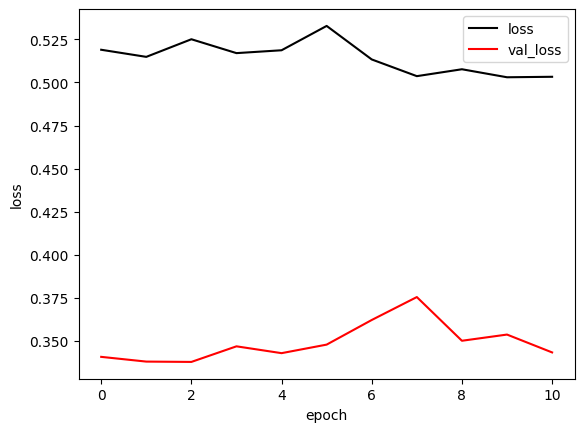

In [70]:
def plot_loss_mlp(history) -> None:
    """ Plot loss and val_loss """
    history_df = pd.DataFrame(history.history)
    plt.figure('loss')
    plt.plot(history_df['loss'], label='loss', c='black')
    plt.plot(history_df['val_loss'], label='val_loss', c='red')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

plot_loss_mlp(history_mlp)

In [71]:
# Predictions on Validation Set
mlp_predictions = mlp_model.predict(X_val)
# Convert probabilities to classes
mlp_predictions_classes = mlp_predictions.argmax(axis=1)

590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


####**Evaluation**

Performance is measured using the classification report and `F1_score` on the validation set.
The model is more flexible than Random Forest, but requires more computing power and attention to adjusting the hyper-parameters.

In [72]:
print("Evaluation of the MLP model:")

# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation of the MLP model:
                    precision    recall  f1-score   support
0 (back)                  1.0       0.0       0.0     143.0
1 (buffer_overflow)       1.0       0.0       0.0       4.0
2 (ftp_write)             1.0       0.0       0.0       1.0
3 (guess_passwd)          1.0       0.0       0.0       8.0
4 (imap)                  1.0       0.0       0.0       2.0
5 (ipsweep)          0.857143  0.011111  0.021938     540.0
6 (land)                  1.0       0.0       0.0       3.0
7 (loadmodule)            1.0       0.0       0.0       1.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.993245  0.998868  0.996049    6183.0
10 (nmap)                 1.0       0.0       0.0     224.0
11 (normal)          0.839046  0.998809  0.911983   10073.0
12 (perl)                 1.0       0.0       0.0       1.0
13 (phf)                  1.0       0.0       0.0       1.0
14 (pod)                  1.0       0.0       0.0      30.0
15 (portswe

##2. Optimisation of hyperparameters

We are going to use two search techniques to find the optimal hyper-parameters of a Random Forest model and a neural network (MLP).

In [73]:
from sklearn.model_selection import GridSearchCV

###Grid Search for Random Forests

Grid Search systematically explores a predefined grid of hyper-parameters and evaluates the performance of each combination using `cross-validation`.

* `n_estimators`: Number of trees in the forest
* `max_depth`: Maximum tree depth
* `min_samples_split`: Minimum number of samples required to subdivide a node
* `min_samples_leaf`: Minimum number of samples in a leaf

In [74]:
param_grid_rf = {
    'n_estimators': [110, 120, 130],
    'max_depth': [None, 10, 20],
    'min_samples_split': list(range(2, 6 + 1)),
    'min_samples_leaf': list(range(1, 4 + 1))
}

The performance of each model is measured by the average `f1_score` calculated by cross-validation.

In [76]:
print("Execution of Grid Search for Random Forest...")
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              cv=2, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Execution of Grid Search for Random Forest...
Fitting 2 folds for each of 180 candidates, totalling 360 fits


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight={0: 70.22594142259415,
                                                            1: 2237.866666666667,
                                                            2: 8392.0,
                                                            3: 1266.7169811320755,
                                                            4: 6103.272727272727,
                                                            5: 18.654070575159768,
                                                            6: 3729.777777777778,
                                                            7: 7459.555555555556,
                                                            8: 9590.857142857143,
                                                            9: 1.6289610326588053,
                                                            10: 44.967180174146016,
                                                            11: 1.0,
                                                            12: 22378.666666666668,
                                                            13: 16784.0,
                                                            14: 334.00995024875624,
                                                            15: 22.905493005800068,
                                                            16: 6713.6,
                                                            17: 18.479493531516653,
                                                            18: 25.372637944066515,
                                                            19: 33568.0,
                                                            20: 75.26457399103138,
                                                            21: 75.43370786516854,
                                                            22: 3356.8},
                                              random_state=3),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [110, 120, 130]},
             scoring='f1_macro', verbose=1)

In [77]:
print("Best parameters found for Random Forest:")
print(grid_search_rf.best_params_)
print(f"Best F1 (Validation Set): {grid_search_rf.best_score_:.2f}")
best_rf_model = grid_search_rf.best_estimator_

Best parameters found for Random Forest:
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120}
Best F1 (Validation Set): 0.75


###Random Search per Rete Neurale (MLP)

Random Search randomly selects parameter combinations from a defined search space, being more efficient for complex models with many hyper-parameters.

In [78]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [79]:
# Define the function to build the MLP model (identical to your existing build_mlp_model)
def build_mlp_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    # Tune the number of units in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=16, max_value=256, step=64)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    # Tune the number of units in the second Dense layer
    hp_units2 = hp.Int('units2', min_value=8, max_value=128, step=32)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(len(y_train.unique()), activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.F1Score(average='macro')])
    return model

# Create a Keras Tuner
tuner = kt.RandomSearch(
    build_mlp_model,
    objective=kt.Objective('val_f1_score', direction='max'),
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=3,  # Number of models to train per combination
)

Each configuration is cross-validated using `f1_score` as the main metric.

In [82]:
print("Performing Random Search for Neural Network...")
early_stopping = keras.callbacks.EarlyStopping(
    min_delta = 0.005,
    patience = 10,
    monitor = 'val_loss',
    mode = 'min',
    restore_best_weights = True
    )

tuner.search(X_train, to_categorical(y_train), epochs=300,
             validation_data=(X_val, to_categorical(y_val)),
             class_weight=weights_dict, callbacks=[early_stopping], verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 10m 04s]
val_f1_score: 0.1816831479469935

Best val_f1_score So Far: 0.5678013761838278
Total elapsed time: 03h 20m 11s


In [83]:
print("Better parameters for the neural network (MLP):")
print(best_hps.values)
print(f"Best F1 (Validation Set): {tuner.oracle.get_best_trials(num_trials=1)[0].score:.2f}")
best_mlp_model = tuner.hypermodel.build(best_hps)

Better parameters for the neural network (MLP):
{'units1': 208, 'dropout1': 0.30000000000000004, 'units2': 40, 'dropout2': 0.2, 'learning_rate': 0.0001}
Best F1 (Validation Set): 0.57


#Training and validation

##Training

In this section, we train the optimised Random Forest and MLP models using preprocessed data. Furthermore, we evaluate their performance both via cross-validation and on the validation set.

In [84]:
!pip install scikit-learn --upgrade
!pip install scikeras --upgrade
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

###1. Random Forest

The optimised Random Forest model is trained on the balanced training data.

In [85]:
print("Random Forest model training optimised...")
best_rf_model.fit(X_train, y_train)

Random Forest model training optimised...


RandomForestClassifier(class_weight={0: 70.22594142259415, 1: 2237.866666666667,
                                     2: 8392.0, 3: 1266.7169811320755,
                                     4: 6103.272727272727,
                                     5: 18.654070575159768,
                                     6: 3729.777777777778, 7: 7459.555555555556,
                                     8: 9590.857142857143,
                                     9: 1.6289610326588053,
                                     10: 44.967180174146016, 11: 1.0,
                                     12: 22378.666666666668, 13: 16784.0,
                                     14: 334.00995024875624,
                                     15: 22.905493005800068, 16: 6713.6,
                                     17: 18.479493531516653,
                                     18: 25.372637944066515, 19: 33568.0,
                                     20: 75.26457399103138,
                                     21: 75.43370786516854, 22: 3356.8},
                       max_depth=20, min_samples_leaf=4, n_estimators=120,
                       random_state=3)

To estimate the robustness of the model, we use cross-validation. The `F1_score` and `standard deviation` are calculated to analyse the variability of performance between the different folds.

In [87]:
print("Performing Cross-Validation for Random Forest...")
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=2, scoring='f1_macro')
print(f"Average f1_macro from Cross-Validation (Random Forest): {cv_scores_rf.mean():.2f} ± {cv_scores_rf.std():.2f}")

Performing Cross-Validation for Random Forest...
Average f1_macro from Cross-Validation (Random Forest): 0.75 ± 0.02


We measure the `f1_score` of the model on the validation set. We generate a classification report highlighting precision, recall and F1-score for each class.

In [88]:
print("Evaluation on the Validation Set (MLP)...")
# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation on the Validation Set (MLP)...
                    precision    recall  f1-score   support
0 (back)                  1.0       0.0       0.0     143.0
1 (buffer_overflow)       1.0       0.0       0.0       4.0
2 (ftp_write)             1.0       0.0       0.0       1.0
3 (guess_passwd)          1.0       0.0       0.0       8.0
4 (imap)                  1.0       0.0       0.0       2.0
5 (ipsweep)          0.857143  0.011111  0.021938     540.0
6 (land)                  1.0       0.0       0.0       3.0
7 (loadmodule)            1.0       0.0       0.0       1.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.993245  0.998868  0.996049    6183.0
10 (nmap)                 1.0       0.0       0.0     224.0
11 (normal)          0.839046  0.998809  0.911983   10073.0
12 (perl)                 1.0       0.0       0.0       1.0
13 (phf)                  1.0       0.0       0.0       1.0
14 (pod)                  1.0       0.0       0.0      30.

###2. Multilayer Perceptron Neural Network (MLP)

The optimised MLP model is trained using pre-processed data and labels in categorical format.

In [94]:
print("Training of the optimised MLP model...")
best_mlp_model = build_mlp_model(best_hps)
best_mlp_model.fit(X_train, to_categorical(y_train))

Training of the optimised MLP model...
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.1059 - loss: 1.8002


We perform a cross-validation for the MLP model, calculating the mean accuracy and standard deviation.

In [96]:
print("Performing Cross-Validation for MLP...")
# Initialise layering
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores_mlp = []

# Manual loop for cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    # Use .iloc to access rows by index
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create the template
    best_mlp_model = build_mlp_model(best_hps)

    # Train the model
    best_mlp_model.fit(X_train_fold, to_categorical(y_train_fold),
                       epochs=300, validation_data=(X_val, to_categorical(y_val)),
                       callbacks = [early_stopping], verbose=1)

    # Predictions
    y_pred = best_mlp_model.predict(X_val_fold).argmax(axis=1)

    # Calculate F1-score
    f1 = f1_score(y_val_fold, y_pred, average='macro')
    cv_scores_mlp.append(f1)

# Mean and standard deviation
print(f"Average f1 from Cross-Validation (MLP): {np.mean(cv_scores_mlp):.2f} ± {np.std(cv_scores_mlp):.2f}")

Performing Cross-Validation for MLP...
Epoch 1/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.0648 - loss: 2.0203 - val_f1_score: 0.1832 - val_loss: 0.4061
Epoch 2/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.1740 - loss: 0.5376 - val_f1_score: 0.2200 - val_loss: 0.2725
Epoch 3/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.2205 - loss: 0.3551 - val_f1_score: 0.2843 - val_loss: 0.2171
Epoch 4/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - f1_score: 0.2710 - loss: 0.2806 - val_f1_score: 0.3134 - val_loss: 0.1786
Epoch 5/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.2772 - loss: 0.2375 - val_f1_score: 0.3336 - val_loss: 0.1573
Epoch 6/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.3363 - loss: 0.2087 - val_f1_score: 0.3852 - val_loss: 0.1447
Epoch 7/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.3477 - loss: 0.1811 - val_f1_score: 0.4230 - val_loss: 0.1274
Epoch 8/300
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6

The model predictions on the validation set are compared with the actual labels. We generate a classification report and measure the overall accuracy.

In [97]:
print("Evaluation on the Validation Set (MLP)...")
mlp_predictions = best_mlp_model.predict(X_val)
mlp_predictions_classes = mlp_predictions.argmax(axis=1)
# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation on the Validation Set (MLP)...
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                    precision    recall  f1-score  support
0 (back)             0.944828  0.958042  0.951389    143.0
1 (buffer_overflow)       1.0       0.0       0.0      4.0
2 (ftp_write)             1.0       0.0       0.0      1.0
3 (guess_passwd)          1.0     0.875  0.933333      8.0
4 (imap)                  1.0       0.0       0.0      2.0
5 (ipsweep)          0.966728  0.968519  0.967623    540.0
6 (land)                 0.75       1.0  0.857143      3.0
7 (loadmodule)            0.0       0.0       0.0      1.0
8 (multihop)              1.0       0.0       0.0      1.0
9 (neptune)          0.997096  0.999677  0.998385   6183.0
10 (nmap)            0.968037  0.946429  0.957111    224.0
11 (normal)           0.99019  0.992058  0.991123  10073.0
12 (perl)                 1.0       1.0       1.0      1.0
13 (phf)                  1.0       0.0       0.0      1.0
14 (pod)                  1.0   

In [98]:
best_mlp_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 208)                 │           6,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 208)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 40)                  │           8,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 23)                  │             943 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,503 (189.47 KB)

 Trainable params: 16,167 (63.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,336 (126.32 KB)

##Evaluation Metrics

We evaluate the performance of the **Random Forest** and **MLP** models on the validation set using the following metrics:

In [99]:
from sklearn.metrics import confusion_matrix

###**1. Classification Ratio**

- **Precision**: The percentage of correct predictions compared to all predictions made for a class.
- **Recall**: The percentage of correctly identified examples compared to all actual examples for a class.
- **F1-Score**: A harmonic average between accuracy and recall.
- **Accuracy**: The percentage of correct predictions out of the total.

In [100]:
# Valutazione del modello Random Forest
print("Evaluation of the Random Forest model on the Validation Set:")
print(f"Evaluation metrics for the model Random Forest:\n")
print(classification_report(y_val, rf_predictions, digits=4, zero_division=1)) # Add zero_division=1 here
print(f"F1_score macro: {f1_score(y_val, rf_predictions, average='macro', zero_division=1):.4f}") # Add zero_division=1 here

Evaluation of the Random Forest model on the Validation Set:
Evaluation metrics for the model Random Forest:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       143
           1     1.0000    0.5000    0.6667         4
           2     1.0000    1.0000    1.0000         1
           3     1.0000    0.8750    0.9333         8
           4     1.0000    0.5000    0.6667         2
           5     0.9945    0.9981    0.9963       540
           6     0.7500    1.0000    0.8571         3
           7     0.5000    1.0000    0.6667         1
           8     1.0000    0.0000    0.0000         1
           9     0.9998    0.9998    0.9998      6183
          10     0.9955    0.9866    0.9910       224
          11     0.9974    0.9995    0.9985     10073
          12     1.0000    1.0000    1.0000         1
          13     1.0000    1.0000    1.0000         1
          14     1.0000    1.0000    1.0000        30
          15     1.0000  

In [101]:
# Valutazione del modello MLP
print("Evaluation of the MLP model on the Validation Set:")
print(f"Evaluation metrics for the model MLP:\n")
print(classification_report(y_val, mlp_predictions_classes, digits=4, zero_division=1)) # Add zero_division=1 here
print(f"F1_score macro: {f1_score(y_val, mlp_predictions_classes, average='macro', zero_division=1):.4f}") # Add zero_division=1 here

Evaluation of the MLP model on the Validation Set:
Evaluation metrics for the model MLP:

              precision    recall  f1-score   support

           0     0.9448    0.9580    0.9514       143
           1     1.0000    0.0000    0.0000         4
           2     1.0000    0.0000    0.0000         1
           3     1.0000    0.8750    0.9333         8
           4     1.0000    0.0000    0.0000         2
           5     0.9667    0.9685    0.9676       540
           6     0.7500    1.0000    0.8571         3
           7     0.0000    0.0000    0.0000         1
           8     1.0000    0.0000    0.0000         1
           9     0.9971    0.9997    0.9984      6183
          10     0.9680    0.9464    0.9571       224
          11     0.9902    0.9921    0.9911     10073
          12     1.0000    1.0000    1.0000         1
          13     1.0000    0.0000    0.0000         1
          14     1.0000    1.0000    1.0000        30
          15     1.0000    0.9636    0.9815  

###**2. Confusion Matrix**.

Provides a visual representation of classification errors for each class. Shows true positives, false positives, true negatives and false negatives, helping to identify possible confusions between classes.

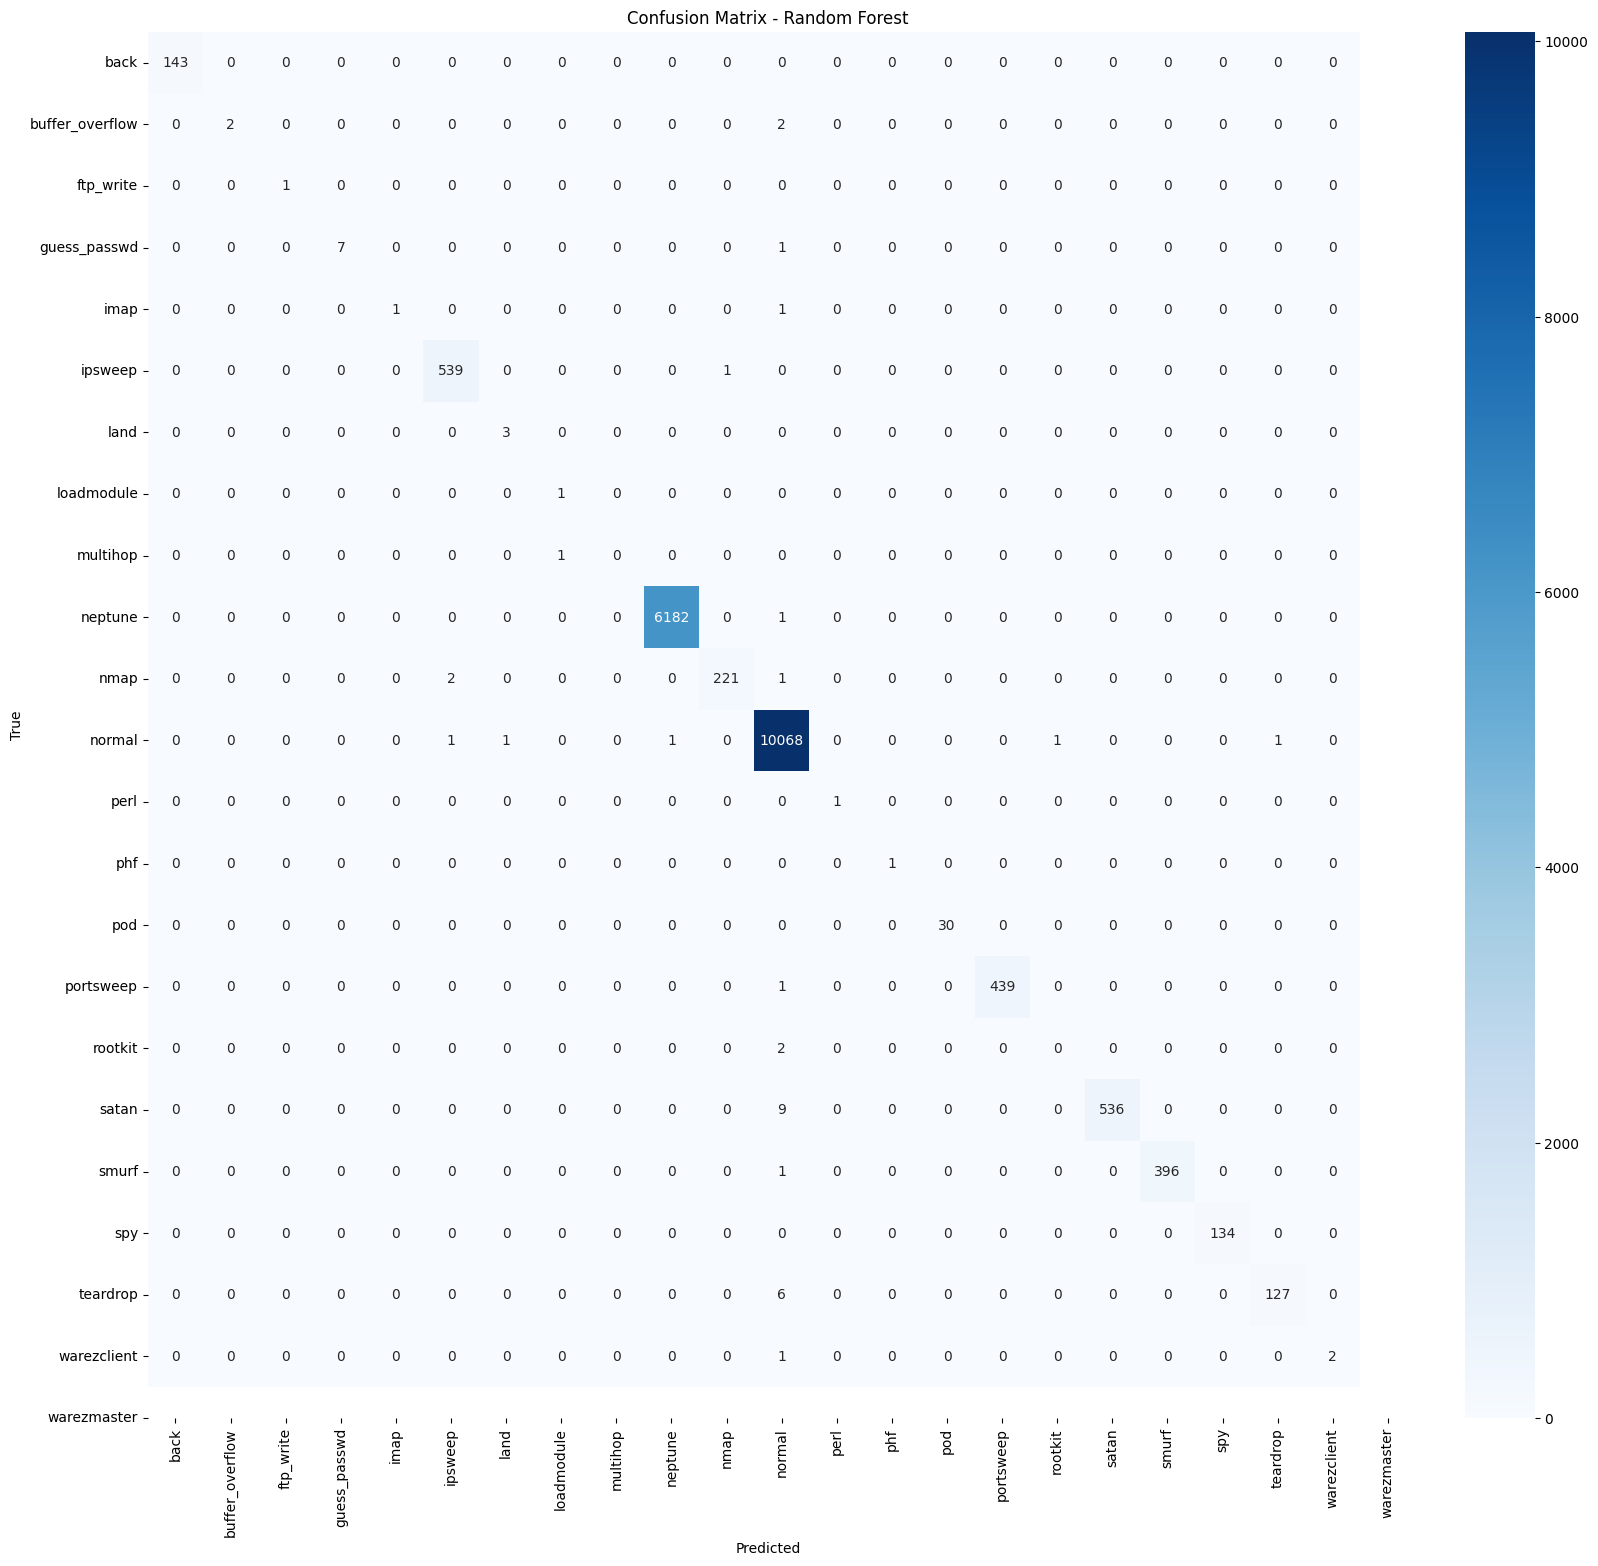

In [111]:
cm = confusion_matrix(y_val, rf_predictions)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 10})  # Reduces the size of numbers

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

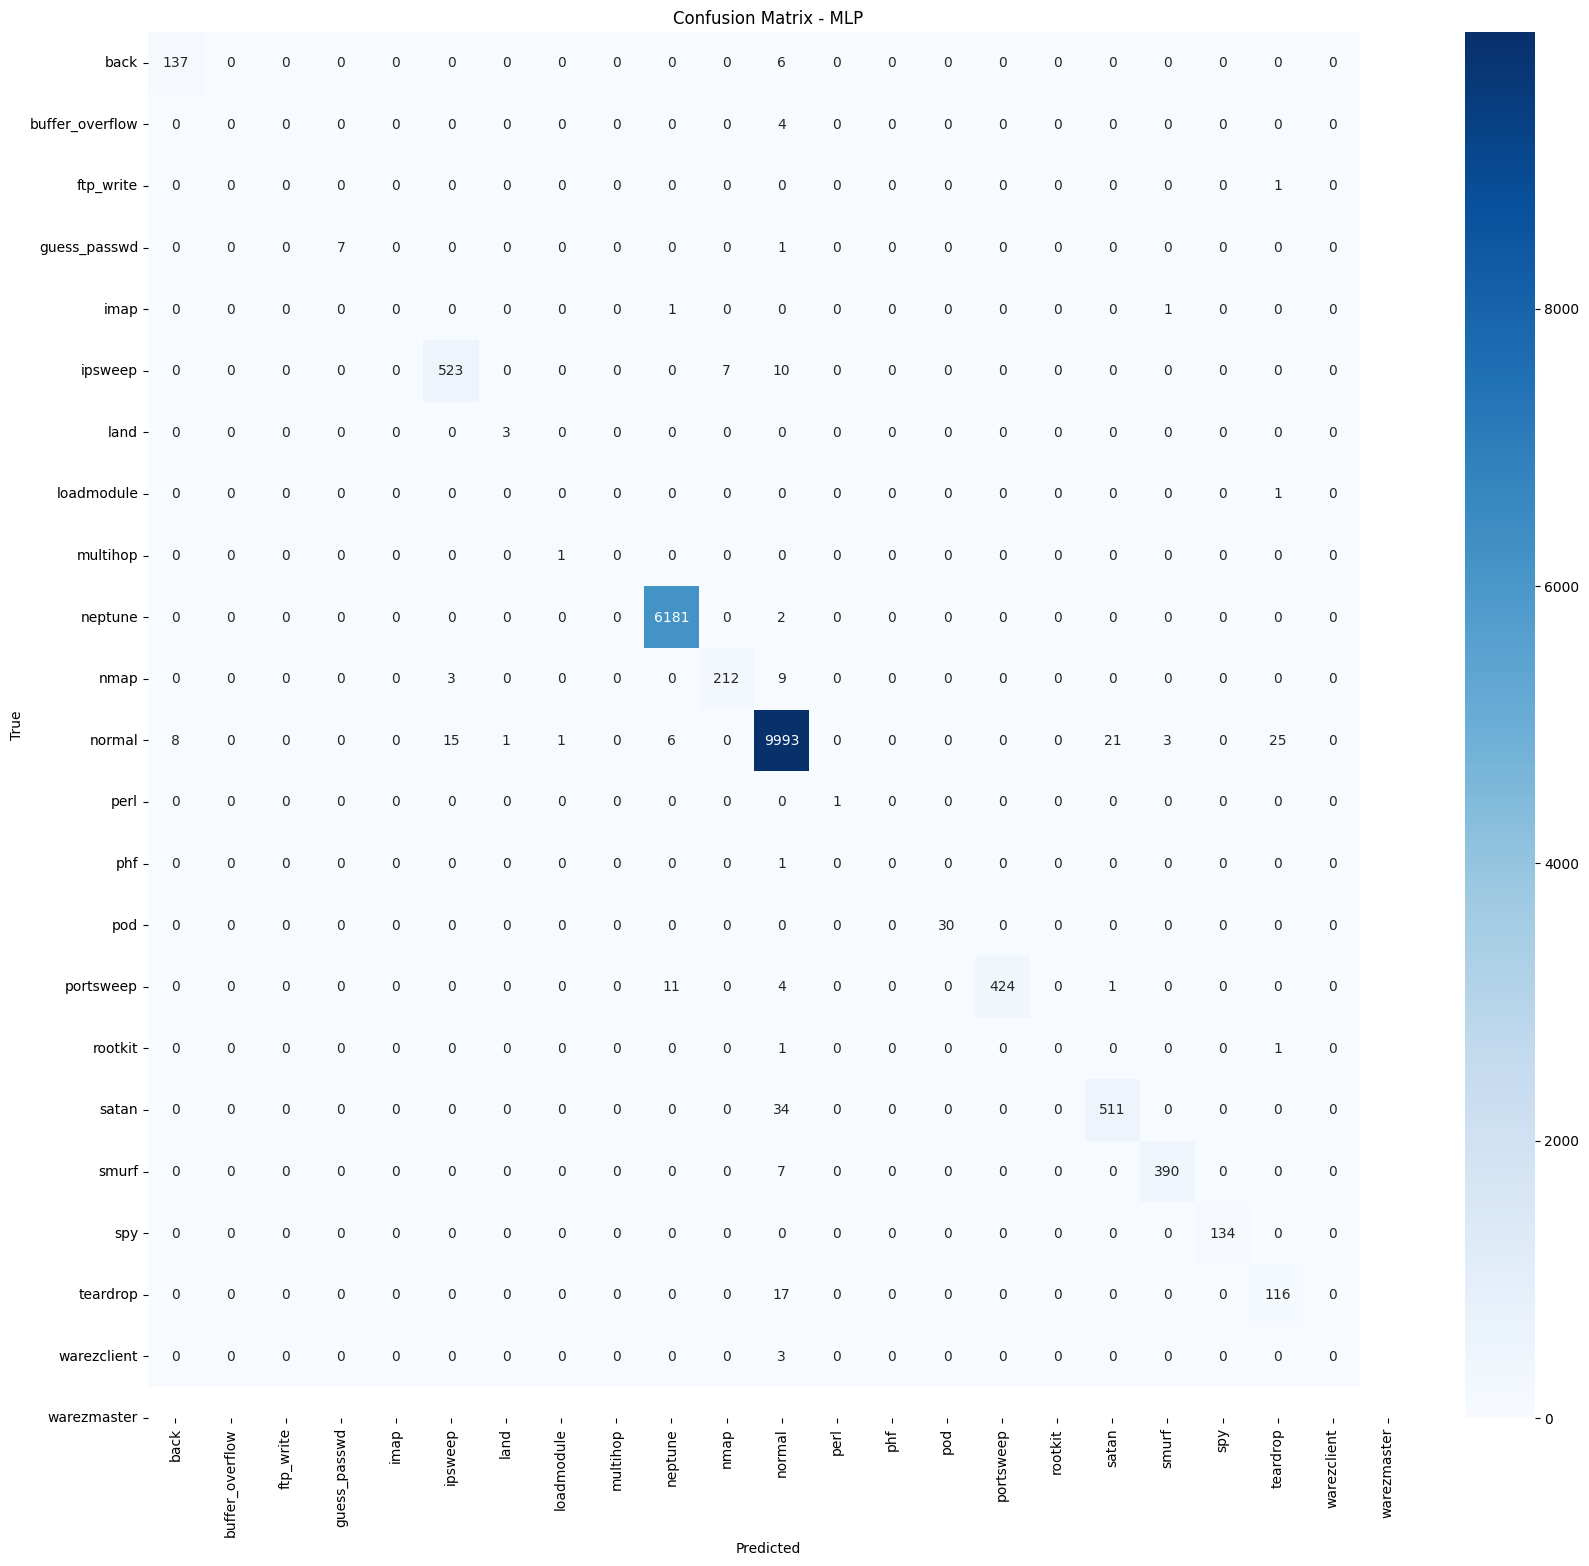

In [110]:
cm = confusion_matrix(y_val, mlp_predictions_classes)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 10})  # Reduces the size of numbers

plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Performance testing and analysis

##Evaluation on the test set

In this section, we perform the final evaluation of the Random Forest and MLP models on the test set to measure their overall performance. We also record the inference time to compare the computational cost of each model.

In [132]:
import time
from sklearn.decomposition import PCA

###Evaluation on Test Set

For each model, we calculate:
- **Classification Report**: Includes detailed metrics such as precision, recall and F1-score for each class.
- **F1-Score**: A harmonic average between accuracy and recall.
- **Inference Time**: Total duration required for the model to process and classify the test set.

In [120]:
# Function for recording inference time and evaluating metrics
def evaluate_on_test_set(model, X_test, y_test, model_name):
    """Evaluate the model on the test set and print metrics."""
    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()

    if model_name == "MLP":
        # Convert y_test to one-hot encoding for MLP evaluation
        y_test = to_categorical(y_test)  # Convert to categorical

        # Calculate loss and accuracy with model.evaluate()
        score = model.evaluate(X_test, y_test, verbose=0)
        print(f'Accuracy on test data: {score[1]:.4f}')
        labels_predicted = predictions.argmax(axis=1)  # Per Softmax
    else:
        labels_predicted = predictions  # No conversion needed for other model

    report = classification_report(y_test.argmax(axis=1) if model_name == "MLP" else y_test, labels_predicted, zero_division=1, output_dict=True)  # zero_division=1 for handling empty classes
    report_df = pd.DataFrame(report).transpose()

    print(f"Classification report for {model_name}:")
    print(report_df)

    accuracy = accuracy_score(y_test.argmax(axis=1) if model_name == "MLP" else y_test, labels_predicted)  # Calculate accuracy
    f1 = f1_score(y_test.argmax(axis=1) if model_name == "MLP" else y_test, labels_predicted, average='weighted')  # Calculate F1 score
    elapsed_time = end_time - start_time

    print(f"\nMetrics for {model_name} on the Test Set:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- F1-score (weighted): {f1:.4f}")
    print(f"- Execution time: {elapsed_time:.4f} seconds")

    return f1, elapsed_time, accuracy

###Models evaluated

In [164]:
def make_scatter_plot(model, data, labels, k, legend, show):
  """
  Creates a scatter plot of the data with different colors for each cluster.

  Args:
      data: The data to plot.
      labels: The cluster labels for the data.
      k: The number of clusters.
      outname: The name of the output file.
  """
  # Create a color map with k distinct colors.
  colors = plt.get_cmap('viridis', k)

  # Create a scatter plot for each cluster.
  for i in range(k):
    plt.scatter(
        data[labels == i][:, 0],
        data[labels == i][:, 1],
        color=colors(i),
        label=f'{i} {label_encoder.classes_[i]}'
    )

  # Add a legend.
  if legend:
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

  # Add labels to the axes.
  plt.xlabel('X')
  plt.ylabel('Y')

  # Set the title of the plot.
  plt.title(f"Scatter Plot of {model}")

  # Show the plot.
  if show:
    plt.show()

  # Clear the plot to avoid overwriting.
  #plt.clf()

####**Random Forest**:

In [121]:
rf_f1, rf_time, rf_accuracy = evaluate_on_test_set(best_rf_model, X_test, y_test, "Random Forest")

Classification report for Random Forest:
              precision    recall  f1-score       support
0              1.000000  1.000000  1.000000    143.000000
1              1.000000  0.800000  0.888889      5.000000
2              1.000000  0.000000  0.000000      1.000000
3              1.000000  1.000000  1.000000      8.000000
4              1.000000  1.000000  1.000000      2.000000
5              0.979927  0.994444  0.987132    540.000000
6              1.000000  1.000000  1.000000      3.000000
7              1.000000  0.000000  0.000000      1.000000
8              1.000000  0.000000  0.000000      1.000000
9              1.000000  0.999838  0.999919   6182.000000
10             0.977679  0.977679  0.977679    224.000000
11             0.998708  0.997716  0.998212  10070.000000
13             1.000000  0.000000  0.000000      1.000000
14             1.000000  1.000000  1.000000     30.000000
15             0.997722  0.995455  0.996587    440.000000
16             0.000000  0.0000

Stampa per Random Forest


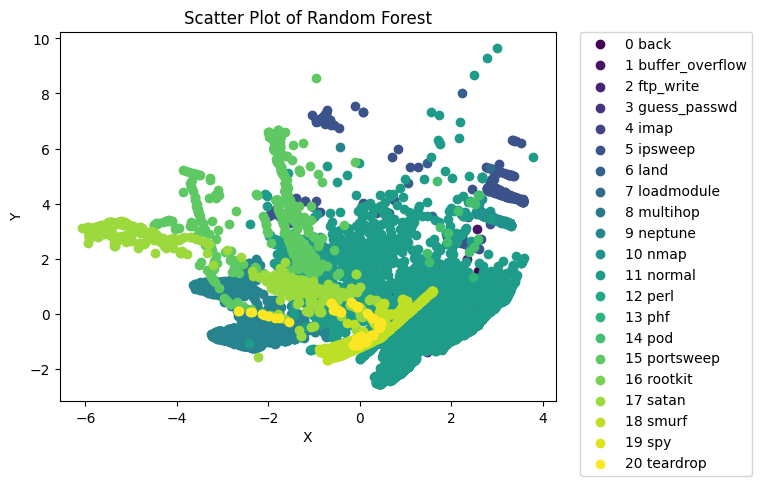

In [165]:
# Standardize the features before applying PCA
scaler = StandardScaler()
X_val_scaled_rf = scaler.fit_transform(X_val)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_val_pca_rf = pca.fit_transform(X_val_scaled_rf)

# Determine the number of unique predicted labels (clusters)
k_rf = len(set(rf_predictions))

print("Stampa per Random Forest")
make_scatter_plot("Random Forest", X_val_pca_rf, rf_predictions, k_rf, 1, 1)

####**MLP (Neural Network)**:

In [145]:
mlp_f1, mlp_time, mlp_accuracy = evaluate_on_test_set(best_mlp_model, X_test, y_test, "MLP")

590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy on test data: 0.5618
Classification report for MLP:
              precision    recall  f1-score       support
0              0.931034  0.944056  0.937500    143.000000
1              1.000000  0.200000  0.333333      5.000000
2              1.000000  0.000000  0.000000      1.000000
3              1.000000  1.000000  1.000000      8.000000
4              1.000000  0.000000  0.000000      2.000000
5              0.957565  0.961111  0.959335    540.000000
6              1.000000  1.000000  1.000000      3.000000
7              1.000000  0.000000  0.000000      1.000000
8              1.000000  0.000000  0.000000      1.000000
9              0.998223  0.999676  0.998949   6182.000000
10             0.945701  0.933036  0.939326    224.000000
11             0.991360  0.991261  0.991310  10070.000000
13             1.000000  0.000000  0.000000      1.000000
14             1.000000  0.966667  0.983051     30.000000
15             0.986333  0.9

Stampa per MLP


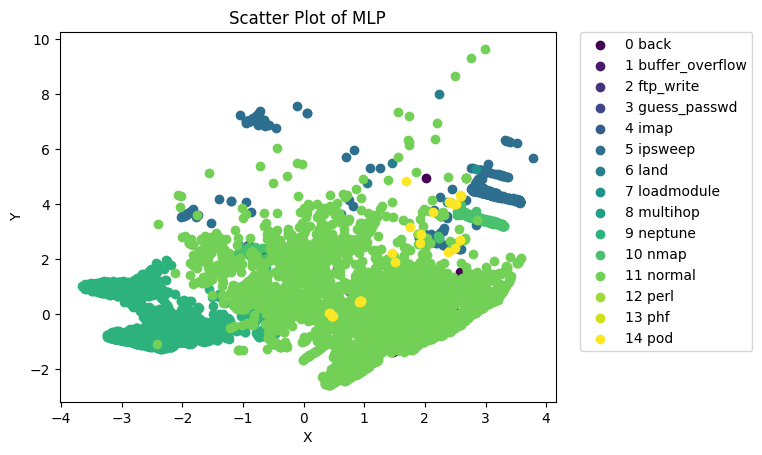

In [166]:
# Standardize the features before applying PCA
scaler = StandardScaler()
X_val_scaled_mlp = scaler.fit_transform(X_val)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_val_pca_mlp = pca.fit_transform(X_val_scaled_mlp)

# Determine the number of unique predicted labels (clusters)
k_mlp = len(set(mlp_predictions_classes))

print("Stampa per MLP")
make_scatter_plot("MLP", X_val_pca_mlp, mlp_predictions_classes, k_mlp, 1, 1)

###Performance Comparison

- **F1-Score**: A harmonic average between accuracy and recall.
- **Computational Cost**: We analyse the inference time to determine the efficiency of each model.

In [148]:
print("Model comparison:")
print(f"Random Forest - F1: {rf_f1:.4f}, Inference Time: {rf_time:.4f} seconds")
print(f"MLP           - F1: {mlp_f1:.4f}, Inference Time: {mlp_time:.4f} seconds")

Model comparison:
Random Forest - F1: 0.9975, Inference Time: 0.4271 seconds
MLP           - F1: 0.9890, Inference Time: 1.0647 seconds


Stampa per MLP
Stampa per Random Forest


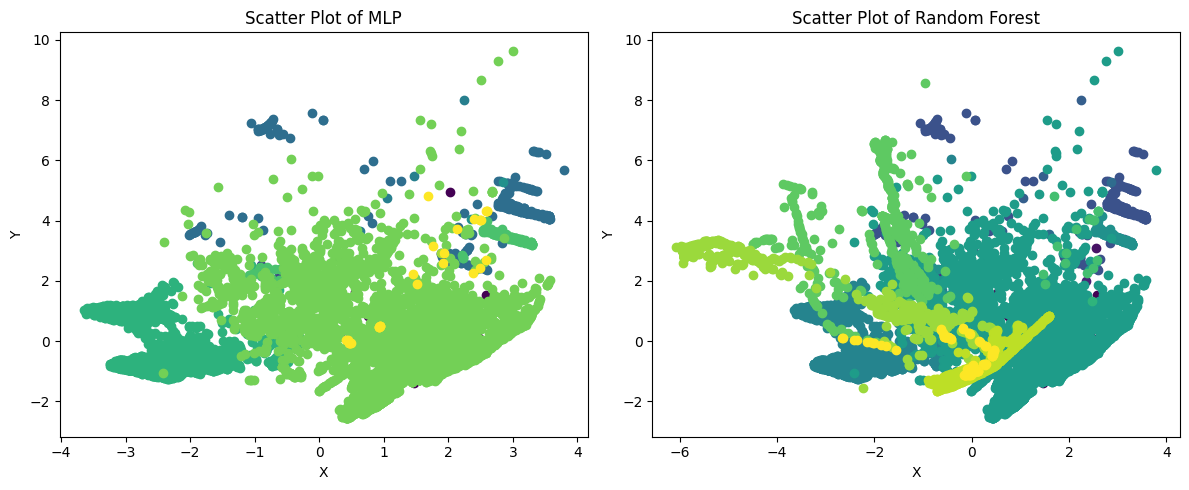

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Stampa per MLP
plt.sca(axes[0])  # Seleziona il primo subplot
print("Stampa per MLP")
make_scatter_plot("MLP", X_val_pca_mlp, mlp_predictions_classes, k_mlp, 0, 0)

# Stampa per Random Forest
plt.sca(axes[1])  # Seleziona il secondo subplot
print("Stampa per Random Forest")
make_scatter_plot("Random Forest", X_val_pca_rf, rf_predictions, k_rf, 0, 0)

# Ottimizza la disposizione dei grafici
plt.tight_layout()
plt.show()

##Feature importance

Analysing the importance of features is an essential step in understanding which variables have the greatest impact on model decision-making. In this section, we use the Random Forest model to identify the most relevant features for multiclass classification.

###1. Calculation of Feature Importance

The Random Forest model provides an attribute called `feature_importances_`, which assigns each feature an importance score based on its ability to reduce impurity during decision tree splits. These scores represent the percentage contribution of each feature to the model's prediction.

In [168]:
print("Calculation of feature importance (Random Forest)...")
feature_importances = best_rf_model.feature_importances_

Calculation of feature importance (Random Forest)...


In [169]:
# Creating a DataFrame to organise data
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

###2. Sorting the Features

Features are sorted according to importance in descending order.

In [170]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

We show the 10 most significant features, both in tabular and visual format.

In [171]:
print("Top 10 most important features:")
print(importance_df.head(10))

Top 10 most important features:
                        Feature  Importance
4                     src_bytes    0.106127
5                     dst_bytes    0.085346
2                       service    0.069465
28           dst_host_srv_count    0.054273
27               dst_host_count    0.050729
7                wrong_fragment    0.046898
30  dst_host_same_src_port_rate    0.046745
29       dst_host_diff_srv_rate    0.046303
0                      duration    0.045255
21                    srv_count    0.040602


###3. Display

We create a bar graph showing the relative importance of the top 10 features. The graph helps to visually identify the key variables that the model considers most influential.

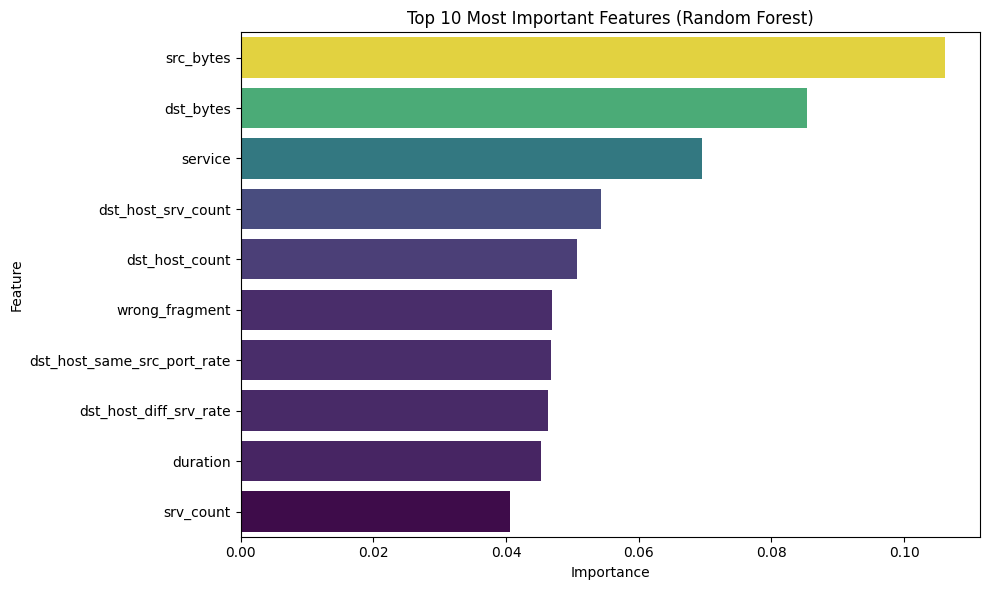

In [172]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), hue='Importance', palette='viridis', legend=False)
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()